In [2]:
# Define dependances
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import urllib.request
import json 
from scipy.stats import linregress
from urllib.request import Request, urlopen
from pprint import pprint

# Import the API key
from api_keys import api_key

# Pull Data for Central London

In [7]:
# Defining data
url = "https://api.cyclestreets.net/v2/collisions.locations?"

# Define coordinates
w = -0.19529421925045196
s = 51.4715990553213
e = -0.06041884946064573
n = 51.54115686360122
bbox = f"{w},{s},{e},{n}"

query_url = f"{url}key={api_key}&bbox={bbox}&casualtiesinclude=cyclist&limit=3&datetime=friendly&jitter=1&zoom=17"
response = requests.get(query_url).json()
# pprint(response)

In [8]:
# Convert dictionary to dataframe
s1 = json.dumps(response)
d1 = json.loads(s1)
df = pd.json_normalize(d1['features'])

In [9]:
# Print length of dataframe
len(df)

28506

In [10]:
# Drop unneeded columns
cycledf = df.drop(columns=["properties.url","properties.apiUrl", "geometry.type"])

#rename columns
cycle_df = cycledf.rename(columns={"properties.id": "ID",
          "properties.datetime" : "Date&Time",
          "properties.severity" : "Severity",
          "properties.casualties" : "Casualties",
          "properties.number_of_casualties" : "# of Casualties",
          "properties.number_of_vehicles" : "# of Vehicles",
          "properties.latitude" : "Latitude",
          "properties.longitude" : "Longitude",
          "geometry.coordinates" : "Coordinates"})

# Display changes
# cycle_df.head()

### Save London Collision Data

In [11]:
# Printing out csv file
cycle_df.to_csv("output_data/cyclingstreets_central_london.csv")

# Map All Collisions

In [193]:
# Read csv file
cycle_df = pd.read_csv("output_data/cyclingstreets_central_london.csv")

# Display data
# cycle_df.head()

In [4]:
# Convert string columns to float
converted_cycle_df = cycle_df[["# of Casualties","# of Vehicles","Latitude","Longitude"]].astype(float)

In [339]:
%%capture --no-display
import hvplot.pandas

# Configure the map plot
map1 = converted_cycle_df.hvplot.points("Longitude","Latitude", size=20, geo=True, tiles="OSM", color="red",
                             frame_width = 800, frame_height = 600, scale = 0.5)

# Save the figure
hvplot.save(map1, 'output_data/centrallondoncycle.html')

# Cannot seem to make this code work even with installing "Selenium"
# hvplot.save(map1, 'centrallondoncycle.png')
# hvplot.save(map1, 'output_data/centrallondoncycle.png')

# Display the map
map1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

# Plot Graphs

### Split Date&Time Column

In [340]:
# Splitting "Date&Time" into seperate columns
cycle_df[['Time', 'Day', 'Month', 'Year']] = cycle_df["Date&Time"].apply(lambda x: pd.Series(str(x).split(" ")))

In [341]:
# Group data by Year and number of casualties
year_sum_df = cycle_df.groupby('Year')['# of Casualties'].sum().to_frame()

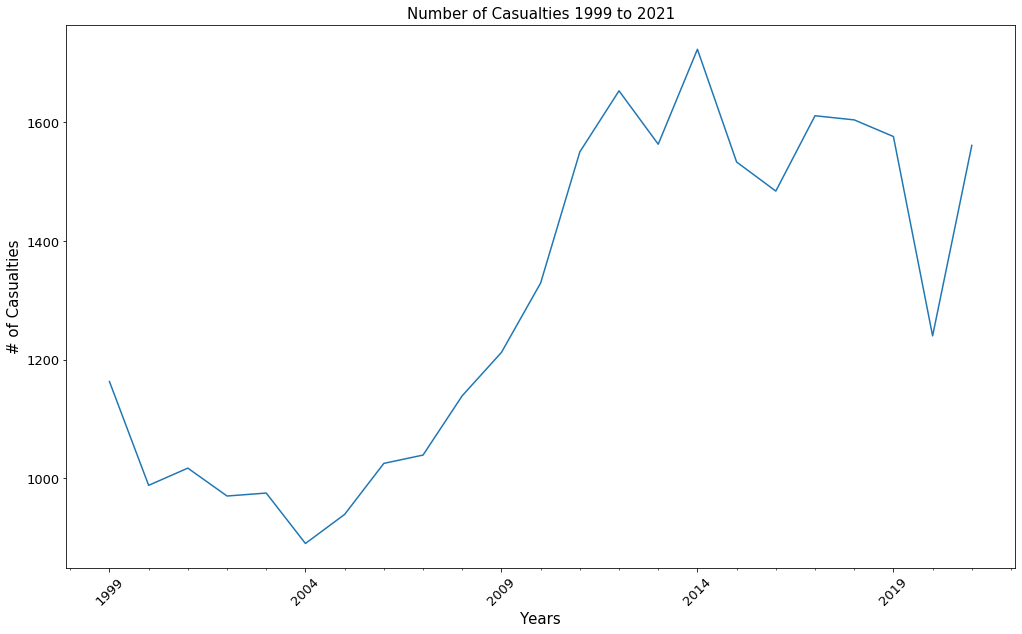

In [342]:
# Plot casualties per year
import matplotlib.ticker as ticker

year_sum_chart = year_sum_df.plot(kind="line", fontsize=13, rot=45, legend=False, figsize=(17,10))

year_sum_chart.set_title("Number of Casualties 1999 to 2021", fontsize=15)
year_sum_chart.set_xlabel("Years", fontsize=15)
year_sum_chart.set_ylabel("# of Casualties", fontsize=15)
year_sum_chart.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# Save the figure
plt.savefig("output_data/Casualties_all_years.png")

plt.show()

In [343]:
# Group data by Year and number of casualties
year_count_df = cycle_df.groupby('Year')['# of Casualties'].value_counts().to_frame()

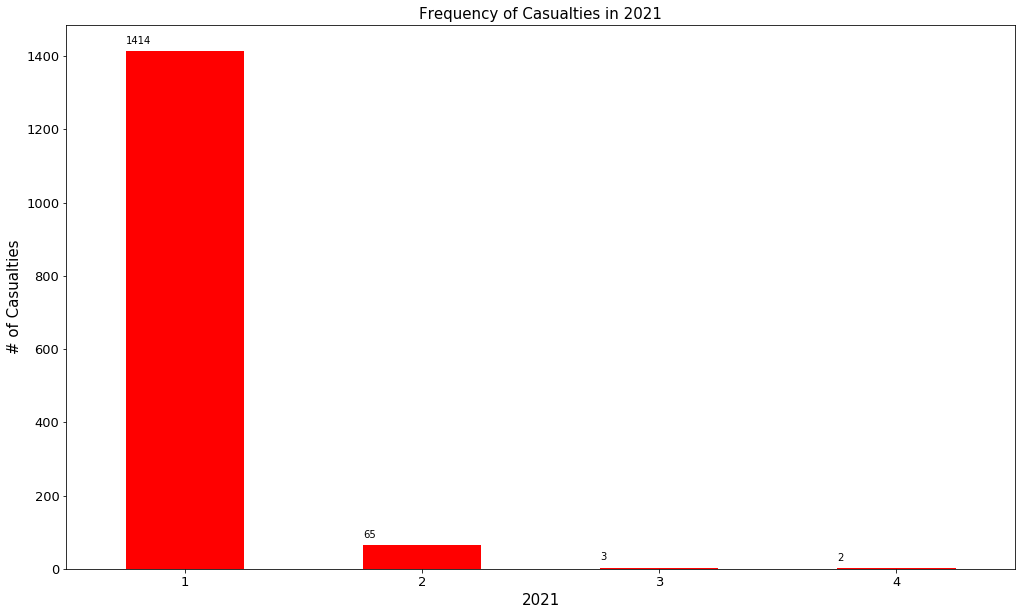

In [344]:
year_ask = "2021"
year = year_count_df.loc[year_ask]

year = year.plot(kind="bar", rot=0, color="red", fontsize=13, legend=False, figsize=(17,10))

year.set_title(f"Frequency of Casualties in {year_ask}", fontsize=15)
year.set_xlabel(year_ask, fontsize=15)
year.set_ylabel("# of Casualties", fontsize=15)

for p in year.patches:
    year.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 20))

# Save the figure
plt.savefig("output_data/Fig2021.png")

plt.show()

In [345]:
# Group data by level of injury to number of casualties
severity_cycle_df = cycle_df.groupby('Severity')['# of Casualties'].sum().to_frame()

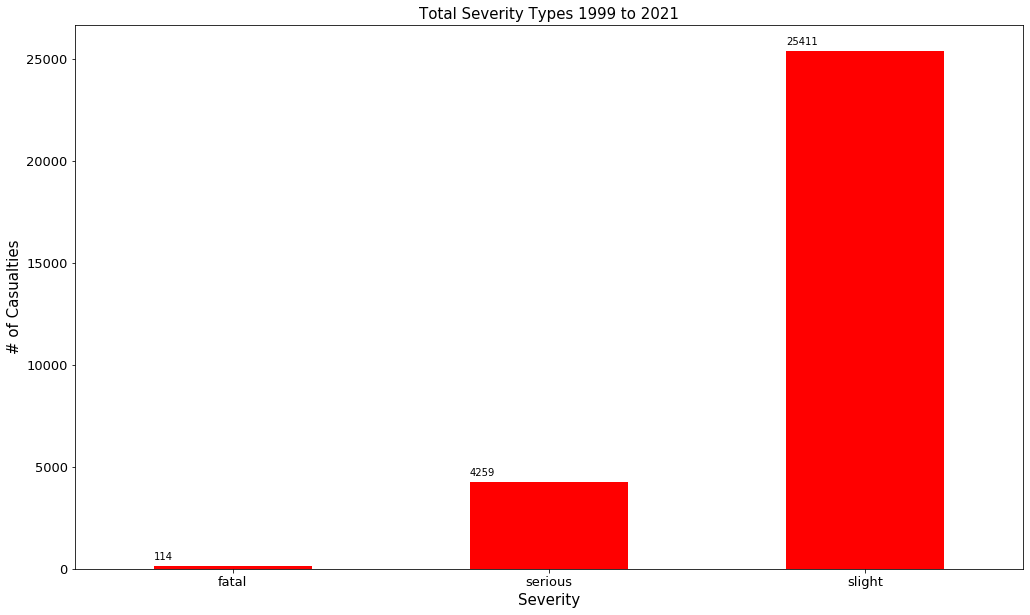

In [346]:
# Plot severity bar graph
severity_values = severity_cycle_df["# of Casualties"]

severity_chart = severity_values.plot(kind="bar", rot=0, color="red", fontsize=13, figsize=(17,10))

severity_chart.set_title(f"Total Severity Types 1999 to 2021", fontsize=15)
severity_chart.set_xlabel("Severity", fontsize=15)
severity_chart.set_ylabel("# of Casualties", fontsize=15)

for p in severity_chart.patches:
    severity_chart.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 300))
    
# Save the figure
plt.savefig("output_data/total_severity_types.png")

plt.show()

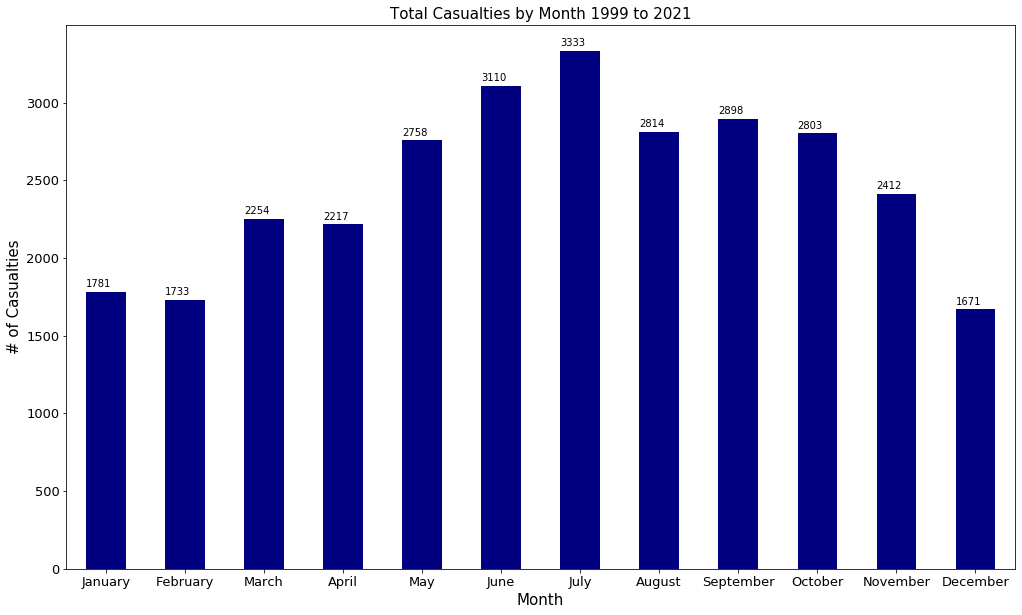

In [347]:
# Group data by month and number of casualties
months = ["January", "February", "March", "April", "May", "June", "July", "August", 
          "September", "October", "November", "December"]

months_df = cycle_df.groupby('Month')['# of Casualties'].sum().to_frame()
sorted_months = months_df.reindex(months)
#sorted_months = months_df.sort_values("# of Casualties", ascending=False)

months_graph = sorted_months.plot(kind="bar", rot=0, color="navy", fontsize=13, legend=False, figsize=(17,10))

months_graph.set_title(f"Total Casualties by Month 1999 to 2021", fontsize=15)
months_graph.set_xlabel("Month", fontsize=15)
months_graph.set_ylabel("# of Casualties", fontsize=15)

for p in months_graph.patches:
    months_graph.annotate(str(p.get_height()), (p.get_x(), p.get_height() + 30))
    
# Save the figure
plt.savefig("output_data/total_casualties_by_month.png")

plt.show()

In [348]:
#cycle_df["Casualties"].unique()
casualty_types_df = cycle_df.groupby('Casualties')['# of Casualties'].sum().to_frame()
casualty_types_df

,# of Casualties
Casualties,
Cyclist,27836
"Cyclist,Bus/coach/minibus occupant",46
"Cyclist,Car occupant",136
"Cyclist,Car occupant,Goods vehicle occupant",4
"Cyclist,Goods vehicle occupant",34
"Cyclist,Motorcycle rider/passenger",601
"Cyclist,Other",17
"Cyclist,Taxi occupant",60
"Pedestrian,Cyclist",1040


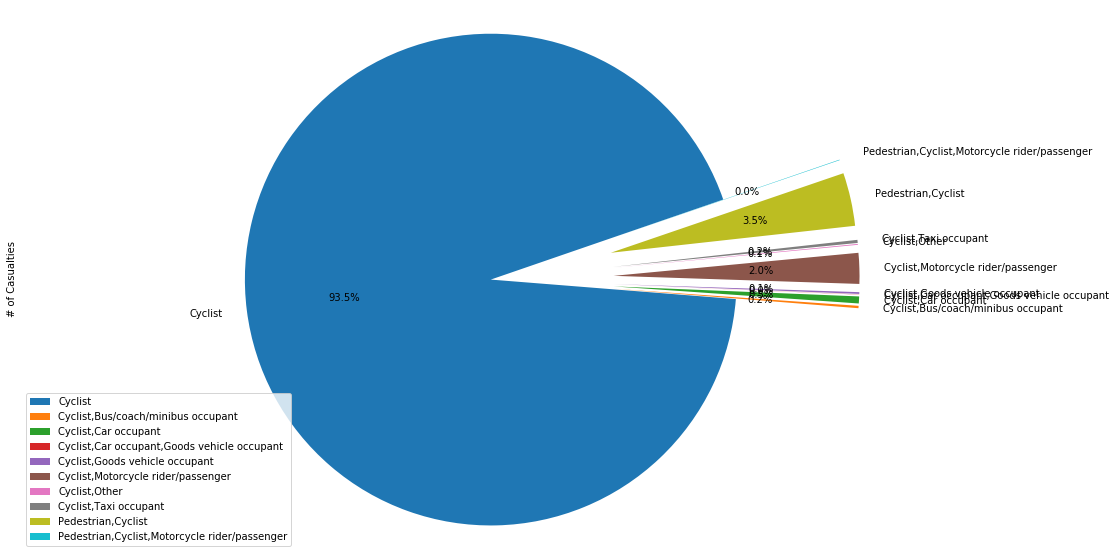

In [349]:
casualty_types_df = cycle_df.groupby('Casualties')['# of Casualties'].sum().to_frame()
casualty_types_graph = casualty_types_df.plot(kind="pie",y="# of Casualties", figsize=(19,10), 
                                              explode=[0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5], 
                                              startangle=19, autopct="%1.1f%%")
casualty_types_graph.axis('equal')
plt.legend(loc='lower left')

# Save the figure
plt.savefig("output_data/casualty_types.png")

plt.show()

In [350]:
fatal_df = cycle_df.loc[cycle_df["Severity"] == "fatal"]
fatal_df["ID"]

482      199901DP00421
640      199901GD00088
699      199901HT00577
891      199901MD00505
990      199901NI00031
             ...      
23523    2018010119906
23711    2018010127131
23834    2018010133528
26055    2020010244580
27812    2021010322598
Name: ID, Length: 107, dtype: object

In [351]:
%%capture --no-display

# Configure the map plot
map2 = fatal_df.hvplot.points("Longitude","Latitude", size=300, geo=True, tiles="OSM", color="yellow",
                             frame_width = 800, frame_height = 600, scale = 0.5)

# Save the figure
hvplot.save(map2, 'output_data/FatalCycleCasualtiesCentralLondon.html')

# Cannot seem to make this code work even with installing "Selenium"
# hvplot.save(map2, 'output_data/FatalCycleCasualtiesCentralLondon.png')
# hvplot.save(map2, 'output_data/FatalCycleCasualtiesCentralLondon.png')

# Display the map
map2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [352]:
serious_df = cycle_df.loc[cycle_df["Severity"] == "serious"]
serious_df["ID"]

0        199901AB00008
7        199901AB00062
24       199901AB00267
31       199901AB00339
49       199901BS00089
             ...      
28492    2021481141695
28496    2021481146458
28501    2021481153478
28502    2021481153745
28504    2021481153896
Name: ID, Length: 3957, dtype: object

In [353]:
%%capture --no-display

# Configure the map plot
map3 = serious_df.hvplot.points("Longitude","Latitude", size=100, geo=True, tiles="OSM", color="yellow",
                             frame_width = 800, frame_height = 600, scale = 0.5)

# Save the figure
hvplot.save(map3, 'output_data/SeriousCycleCasualtiesCentralLondon.html')

# Cannot seem to make this code work even with installing "Selenium"
# hvplot.save(map3, 'output_data/SeriousCycleCasualtiesCentralLondon.png')
# hvplot.save(map3, 'output_data/SeriousCycleCasualtiesCentralLondon.png')

# Display the map
map3

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]